# Helper Functions

In [2]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

db = 'chinook.db'

# Function to run our SQL query
def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)

# Function to run a query that does not involve any table modifications
def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)

# Function to list all our tables
def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(q)

# Analyzing Sales by Music Genre

In [4]:
# query will return us the top ten music genre by total sales as well
q = '''
    WITH genre_sales_usa AS
        (
            SELECT il.*, g.*, c.country  FROM invoice_line il
            INNER JOIN invoice i ON il.invoice_id = i.invoice_id
            INNER JOIN customer c on i.customer_id = c.customer_id
            INNER JOIN track t ON il.track_id = t.track_id
            INNER JOIN genre g ON t.genre_id = g.genre_id
            WHERE c.country = 'USA'
        )
    SELECT
        name genre, 
        SUM(quantity) tracks_sold, 
        CAST(SUM(quantity) as FLOAT)/ (SELECT COUNT(*) FROM genre_sales_usa) percentage_sold 
    FROM genre_sales_usa
    GROUP BY 1
    ORDER BY tracks_sold DESC
    LIMIT 10
    '''
run_query(q)

,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


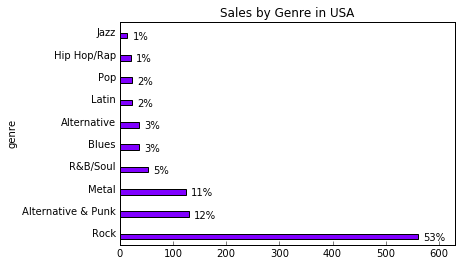

In [5]:
genre_sales_usa = run_query(q)

# Set our index to the genre
genre_sales_usa.set_index("genre", inplace=True)

#Set up our bar chart
genre_sales_usa.plot.barh( xlim=(0, 630), title="Sales by Genre in USA", colormap=plt.cm.rainbow)

# Add annotations to our chart for better readability
for i, label in enumerate(genre_sales_usa.index):
    pct_sold = str(int(genre_sales_usa.loc[label, "percentage_sold"] * 100)) + "%"
    plt.text(
        genre_sales_usa.loc[label, "tracks_sold"] + 10, 
        i - 0.3, 
        pct_sold, 
        color="black", 
        fontweight="light"
    ) 

plt.tick_params(left="off", top="off", right="off")
plt.legend().set_visible(False)
plt.show()

<p>We clearly see the Rock Genre in the USA possessing the majority of sales. However, based on the 4 albums given, the following three would be the best choices</p>
<ol>
    <li>
        Red Tone (Punk)
    </li>
    <li>
        Slim Jim Bites (Blues)
    </li>
    <li>
        Meteor and the Girls (Pop)
    </li>
</ol>
<p></p>

# Analyzing sales by Sales Support Agent

In [6]:
# The following query will get us the sales support agent with the best sales
q = '''
    WITH customer_sales AS 
    (
        SELECT e.*, i.customer_id, SUM(i.total) total FROM employee e
        INNER JOIN customer c ON e.employee_id = c.support_rep_id
        INNER JOIN invoice i ON c.customer_id = i.customer_id
        GROUP BY i.customer_id
    )
    SELECT
    first_name || " " || last_name AS employee_name,
    hire_date,
    SUM(total) total_sales
    FROM customer_sales
    GROUP BY employee_id
    ORDER BY total_sales DESC
    '''
run_query(q)

,employee_name,hire_date,total_sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


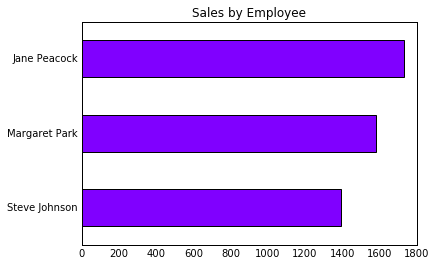

In [7]:
employee_sales = run_query(q)

# Set the index to employee_name 
employee_sales.set_index("employee_name", inplace=True)

# Sort the values in our dataframe by total_sales
employee_sales.sort_values("total_sales", inplace=True)

# Create our chart
employee_sales.plot.barh( title="Sales by Employee", colormap=plt.cm.rainbow)

plt.legend().set_visible(False)
plt.tick_params(left="off", top="off", right="off", bottom="off")
plt.ylabel('')
plt.show()

<p>From the graph, we see that the employees that have been working for the company longer achieved more sales</p>

# Examining Customer Sales by Country

In [8]:
# The following query return us aggregate data on sales by country
q = '''
    WITH countries_as_other AS 
    (
        SELECT
            CASE
                WHEN (
                    SELECT COUNT(*) FROM customer WHERE country = c.country
                ) = 1 THEN "Other"
                ELSE c.country
            END AS country,
            c.*
        FROM customer c
    ),
    customer_sales_country AS
    (
        SELECT 
            COUNT(DISTINCT c.customer_id) total_customers,
            SUM(il.unit_price) total_sales,
            SUM(il.unit_price)/COUNT(DISTINCT i.invoice_id) sales_avg,
            SUM(il.unit_price)/COUNT(DISTINCT c.customer_id) average_order_val,
            c.country
        FROM countries_as_other c
        INNER JOIN invoice i ON c.customer_id = i.customer_id
        INNER JOIN invoice_line il ON i.invoice_id = il.invoice_id
        GROUP BY c.country
        ORDER BY total_sales DESC
    ),
    country_sales_sort AS (
        SELECT 
            *,
            CASE
                WHEN c.country = "Other" THEN 1
                ELSE 0
            END AS sort
        FROM customer_sales_country c
        ORDER BY sort ASC
    )
   
    SELECT * FROM country_sales_Sort
    '''
run_query(q)

,total_customers,total_sales,sales_avg,average_order_val,country,sort
0,13,1040.49,7.942672,80.037692,USA,0
1,8,535.59,7.047237,66.948750,Canada,0
2,5,427.68,7.011148,85.536000,Brazil,0
3,5,389.07,7.781400,77.814000,France,0
4,4,334.62,8.161463,83.655000,Germany,0
5,2,273.24,9.108000,136.620000,Czech Republic,0
6,3,245.52,8.768571,81.840000,United Kingdom,0
7,2,185.13,6.383793,92.565000,Portugal,0
8,2,183.15,8.721429,91.575000,India,0
9,15,1094.94,7.448571,72.996000,Other,1


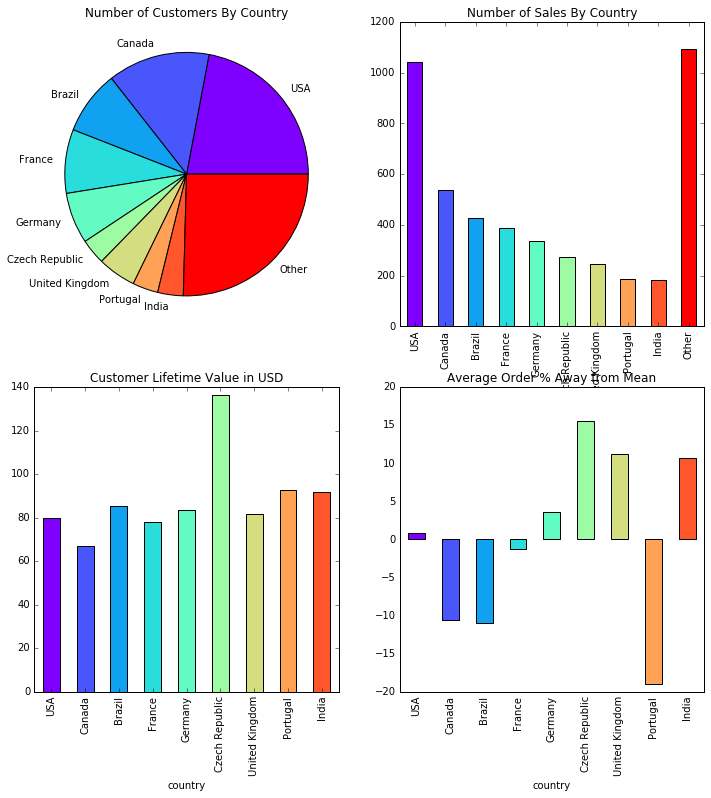

In [9]:
customers_by_country = run_query(q)

# Set index to country
customers_by_country.set_index("country", inplace=True)

# Get the colors for each of the country
colors = [plt.cm.rainbow(i) for i in np.linspace(0, 1, customers_by_country.shape[0])]

# Initialize our plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
ax1, ax2, ax3, ax4 = axes.flatten()

# Have dataset without "Other" index
filtered_data = customers_by_country.drop("Other")

# Top Left Plot
customers_by_country.loc[:,"total_customers"].plot.pie(
    ax=ax1, 
    title="Number of Customers By Country",
    colormap=plt.cm.rainbow
)
ax1.set_ylabel('')

# Top Right Plot
customers_by_country.loc[:,"total_sales"].plot.bar(
    ax=ax2, 
    title="Number of Sales By Country",
    color=colors
)

# Bottom Left Plot
filtered_data.loc[:, "average_order_val"].plot.bar(
    ax=ax3, 
    title="Customer Lifetime Value in USD",
    color=colors
)

# Bottom Right Plot
# Calculate grand mean
grand_mean = filtered_data.loc[:,"sales_avg"].mean()

# Get percent difference from grand mean for each country
filtered_data.loc[:,"pct_from_grand_mean"] = filtered_data.loc[:,"sales_avg"].apply(lambda x: ((x-grand_mean)/grand_mean)*100)
filtered_data.loc[:,"pct_from_grand_mean"].plot.bar(
    ax=ax4, 
    title="Average Order % Away from Mean",
    color=colors
)
ax4.tick_params(top="off", right="off", left="off", bottom="off")

<p>According to the data, <strong>Czech Republic</strong>, <strong>United Kingdom</strong> and <strong>India</strong> have strong potential for growth</p>

In [10]:
# The following query will determine the total album sales and total track sales
# We don't know whether an invoice is an album or track sale so we need to perform some
# extra work to determine if the collection of tracks is from a single album
q = '''
    WITH invoice_with_is_album AS 
    (

        SELECT 
            *,
            CASE 
                WHEN COUNT(DISTINCT t.album_id) = 1 
                AND
                COUNT(DISTINCT t.track_id) 
                =
                (
                 SELECT 
                    COUNT(DISTINCT t3.track_id)
                FROM track t3
                WHERE t3.album_id = 
                    (
                        SELECT 
                            MIN(t.album_id)
                        FROM invoice i0
                        INNER JOIN invoice_line il0 ON i0.invoice_id = il0.invoice_id 
                        INNER JOIN track t0 ON il0.track_id = t0.track_id
                        GROUP BY i0.invoice_id
                  )
                ) THEN "yes"
                ELSE "no"
            END AS album_purchase
        FROM invoice i1
        INNER JOIN invoice_line il ON i1.invoice_id = il.invoice_id 
        INNER JOIN track t ON il.track_id = t.track_id
        GROUP BY il.invoice_id
    )
    SELECT 
        album_purchase,
        COUNT(*) invoice_count, 
        CAST(COUNT(*) AS FLOAT) / (SELECT COUNT(*) FROM invoice_with_is_album) invoice_pct 
    FROM invoice_with_is_album GROUP BY album_purchase;
'''

run_query(q)

,album_purchase,invoice_count,invoice_pct
0,no,500,0.814332
1,yes,114,0.185668


<p>According to the results of our SQL Query, it is clear that most customers purchase individual tracks that albums. Therefore we should advise management to purchase the most popular tracks from record companies </p>